In [117]:
import os
import pandas as pd
import logging

logger = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Получаем путь к scrapped_videos_csv
current_directory = os.getcwd()

directory = current_directory + '\Scrapped_videos_csv'

## EDA

Итак, приступим к осмотру нашего датасета.

In [156]:
df_cleaned = pd.read_csv(directory + '\\' + 'all_videos_data_no_duplicates.csv')

Рассмотрим вообще соотношение кол-ва данных с Rutube и Youtube

In [160]:
df_cleaned['source'].value_counts()

Rutube     6219
Youtube    3141
Name: source, dtype: int64

In [161]:
df_cleaned['source'].value_counts() / df_cleaned.shape[0]

Rutube     0.664423
Youtube    0.335577
Name: source, dtype: float64

Видим, что 66% данных взяты из rutube, а 33% - из youtube. Это важно помнить в дальнейшем анализе 

Далее поймем, какие столбцы нам точно не понадобятся в дальнейшем.  
Можно убрать video_id, video_title, channel_id, channel_name, channel_description, description, как незначительные признаки.

In [164]:
df_cleaned = df_cleaned.drop(columns=['video_id', 'video_title', 'channel_id', 'channel_name', 'channel_description', 'description'])

Далее посмотрим на пропуски в наших данных

In [165]:
df_cleaned.isna().sum()

published_at         0
views                0
likes             2139
comments          2035
category             5
subscribers        231
videos_count       231
source               0
comments_likes    6219
tags              7831
dtype: int64

У нас есть одинаковое кол-во пропусков в полях subscribers и videos_count. Посмотрим на эти строки

In [138]:
df_cleaned[(df_cleaned['subscribers'].isna()) & (df_cleaned['videos_count'].isna())]

,published_at,views,likes,comments,category,subscribers,videos_count,source,comments_likes,tags
100,2024-08-25T22:54:22,26097,2134.0,143.0,Разное,NaN,NaN,Rutube,NaN,NaN
869,2024-07-07T16:53:11,11422,963.0,45.0,Разное,NaN,NaN,Rutube,NaN,NaN
995,2024-06-30T18:57:11,12329,941.0,128.0,Разное,NaN,NaN,Rutube,NaN,NaN
1128,2024-06-23T10:00:02,44718,169.0,6.0,Обучение,NaN,NaN,Rutube,NaN,NaN
1465,2024-06-07T14:05:38,102806,660.0,392.0,ПМЭФ,NaN,NaN,Rutube,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
4285,2025-01-27T16:00:59,80398,NaN,NaN,Новости и СМИ,NaN,NaN,Rutube,NaN,NaN
4287,2025-01-26T12:00:29,11702,NaN,NaN,Психология,NaN,NaN,Rutube,NaN,NaN
4288,2025-01-27T10:00:57,64801,NaN,NaN,Развлечения,NaN,NaN,Rutube,NaN,NaN
4289,2025-01-27T18:23:06,46480,NaN,NaN,Телепередачи,NaN,NaN,Rutube,NaN,NaN


In [139]:
df_cleaned[(df_cleaned['subscribers'].isna()) & (df_cleaned['videos_count'].isna())].value_counts('source')

source
Rutube    231
dtype: int64

Как мы видим, там, где нет кол-ва подписчиков, там и нет кол-ва видео на канале. Причем все такие случаи на Rutube.  
Вероятно это каналы, которые были удалены/скрыты и информация о них недоступна, хотя сами видео на площадке остались. Что-ж, такие у них правила.  
Глобально, раз статистика по видео в таких строках доступна, то можем оставить такие строки и заполнить subscribers и videos_count средним значением по Rutube

In [140]:
df_cleaned_rutube = df_cleaned[df_cleaned['source'] == 'Rutube']

df_cleaned['subscribers'] = df_cleaned['subscribers'].fillna(df_cleaned_rutube['subscribers'].mean())
df_cleaned['videos_count'] = df_cleaned['videos_count'].fillna(df_cleaned_rutube['videos_count'].mean())

In [141]:
df_cleaned.isna().sum()

published_at         0
views                0
likes             2139
comments          2035
category             5
subscribers          0
videos_count         0
source               0
comments_likes    6219
tags              7831
dtype: int64

Далее рассмотрим пропуски в лайках и комментариях. Прежде всего увидим, на каких платформах такие пропуски более часты

In [142]:
df_cleaned[df_cleaned['likes'].isna()].value_counts('source')

source
Rutube     2035
Youtube     104
dtype: int64

In [143]:
df_cleaned[df_cleaned['comments'].isna()].value_counts('source')

source
Rutube    2035
dtype: int64

Видно, что такие пропуски зачатую в Rutube, причем исходя из совпадающей цифры на Рутубе, если отключены комментарии, то отключены и лайки. Посмотрим, как выглядят строки с такими пропусками на рутубе

In [169]:
df_cleaned[(df_cleaned['source'] == 'Rutube') & ((df_cleaned['comments'].isna()) | (df_cleaned['likes'].isna()))]

,published_at,views,likes,comments,category,subscribers,videos_count,source,comments_likes,tags
0,2025-03-02T12:01:11,23261,NaN,NaN,Авто-мото,66937.0,298.0,Rutube,NaN,NaN
3,2025-03-02T10:00:46,19553,NaN,NaN,Развлечения,45950.0,1092.0,Rutube,NaN,NaN
4,2025-03-02T10:00:26,28075,NaN,NaN,Культура,155359.0,195.0,Rutube,NaN,NaN
6,2025-03-02T10:47:59,11505,NaN,NaN,Авто-мото,8411.0,462.0,Rutube,NaN,NaN
8,2025-03-01T18:50:18,6593,NaN,NaN,Фильмы,11021.0,150.0,Rutube,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
6188,2024-12-12T12:01:29,4993,NaN,NaN,Психология,13127.0,156.0,Rutube,NaN,NaN
6208,2024-12-11T14:18:44,9638,NaN,NaN,Интервью,15262.0,143.0,Rutube,NaN,NaN
6210,2024-12-12T17:25:30,28736,NaN,NaN,Разное,85021.0,1313.0,Rutube,NaN,NaN
6214,2024-12-12T19:02:01,30979,NaN,NaN,Новости и СМИ,54006.0,265.0,Rutube,NaN,NaN


Объединение получилось ровно 2035, поэтому гипотеза оказалась верна. Такие строки мы удалим, потому что дальнейшему анализу они мало будут полезны  
Однако отсутствующие лайки на ютубе мы заменим на среднее значение, т.к. там всего 104 пропуска, т.е. +-3% от всех ютубовских строк

In [173]:
df_cleaned = df_cleaned[(df_cleaned['source'] == 'Youtube') | ((df_cleaned['source'] == 'Rutube') & (~df_cleaned['likes'].isna()))]
df_cleaned['source'].value_counts()

Rutube     4184
Youtube    3141
Name: source, dtype: int64

In [175]:
df_cleaned['likes'] = df_cleaned['likes'].fillna(df_cleaned[df_cleaned['source'] == 'Youtube']['likes'].mean())

In [176]:
df_cleaned.isna().sum()

published_at         0
views                0
likes                0
comments             0
category             5
subscribers         26
videos_count        26
source               0
comments_likes    4184
tags              5796
dtype: int64

Отлично! Теперь видео с двух ресурсов в более равных пропорциях относительно друг друга в датасете.  
Строки с пропусками в category, subscribers и videos_count уберем из-за того, что их кол-во незначительно

In [177]:
df_cleaned = df_cleaned.dropna(subset=['category', 'subscribers', 'videos_count'])
df_cleaned.isna().sum()

published_at         0
views                0
likes                0
comments             0
category             0
subscribers          0
videos_count         0
source               0
comments_likes    4158
tags              5769
dtype: int64

Остались два поля: comments_likes и tags. Они есть только у ютубовских строк. Таким образом comments_likes нет только у всех rutube видео, а tags нет у некоторых видео на ютубе.  
Тогда там можно убирать пропуски при их непосредственном анализе

In [145]:
df_cleaned[df_cleaned['source'] != 'Youtube']['category'].unique()

array(['Авто-мото', 'Новости и СМИ', 'Развлечения', 'Культура', 'Фильмы',
       'Разное', 'Обучение', 'Телепередачи', 'Политика', 'Путешествия',
       'Лайфстайл', 'Интервью', 'Животные', 'Аниме', 'Детям', 'Спорт',
       'Сериалы', 'Юмор', 'Недвижимость', 'Психология', 'Еда',
       'Видеоигры', 'Технологии и интернет',
       'Бизнес и предпринимательство', 'Музыка', 'Наука',
       'Обзоры и распаковки товаров', 'Эзотерика', 'Мультфильмы',
       'Летник RUTUBE', 'Строительство и ремонт', 'Красота', 'Хобби',
       'Техника и оборудование', 'Лайфхаки', 'Здоровье', 'Природа',
       'Гид RUTUBE: города России', 'Сад и огород', 'Спецпроекты', 'ПМЭФ',
       'Дизайн', '80 лет Великой Победе', 'Активность: «Контент-прорыв»',
       'Аудиокниги', 'Акция «Весна на экране»',
       'Акция «RUTUBE — это по любви»', 'Религия',
       'Акция «2024 — встречай!»', 'Включи Новый год'], dtype=object)

In [146]:
df_cleaned[df_cleaned['source'] == 'Youtube']['category'].unique()

array(['Comedy', 'People & Blogs', 'Film & Animation', 'Sports',
       'Science & Technology', 'News & Politics', 'Entertainment',
       'Gaming', 'Music', 'Autos & Vehicles', 'Howto & Style',
       'Education', 'Travel & Events', 'Pets & Animals', nan],
      dtype=object)

Также, мы посмотрим на общую информацию по датасету и соответствие типов данных правильным:

In [147]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9360 entries, 0 to 9359
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   published_at    9360 non-null   object 
 1   views           9360 non-null   int64  
 2   likes           7221 non-null   float64
 3   comments        7325 non-null   float64
 4   category        9355 non-null   object 
 5   subscribers     9360 non-null   float64
 6   videos_count    9360 non-null   float64
 7   source          9360 non-null   object 
 8   comments_likes  3141 non-null   object 
 9   tags            1529 non-null   object 
dtypes: float64(4), int64(1), object(5)
memory usage: 731.4+ KB


Видно, что published_at поле у нас не определилось как дата, мы исправим это в коде ниже:

In [148]:
df_cleaned['published_at'] = pd.to_datetime(df_cleaned['published_at'], errors='coerce')

И на всякий случай проверим, что у нас нет отрицательных значений:

In [153]:
numeric_cols = ['views', 'likes', 'comments', 'subscribers', 'videos_count']

for col in numeric_cols:
    if col in df_cleaned.columns:
        negative_rows = df_cleaned[df_cleaned[col] < 0]
        count = negative_rows.shape[0]
        print(f"В столбце '{col}' найдено {count} отрицательных значений.")

В столбце 'views' найдено 0 отрицательных значений.
В столбце 'likes' найдено 0 отрицательных значений.
В столбце 'comments' найдено 0 отрицательных значений.
В столбце 'subscribers' найдено 0 отрицательных значений.
В столбце 'videos_count' найдено 0 отрицательных значений.


Изучить особенности данных в рамках объединённого датасета:  
Есть ли пропущенные значения? Сколько? Какова их доля от общего числа объектов для каждого конкретного признака? И, в целом, насколько ваш датасет “разрежен” в контексте пропущенных значений? Выдвинуть и (желательно) проверить гипотезу, что могут означать пропущенные значения? Осмысленно и аргументированно обработать пропуски.  
Есть ли ошибочные (например, отрицательный возраст или пятиметровый рост человека; 3-й класс в задаче бинарной классификации) значения (признаки, целевая переменная) в данных? Обработать их.  
Есть ли выбросы в данных? По возможности обработать их.  
Изучить поведение каждого признака в отдельности, его связь с целевой переменной, а также попарные корреляции (в том числе и в особенности с таргетом). Визуализировать попарные распределения признаков и корреляции наиболее значимых.  
Построить подходящие сводные таблицы и прочие диаграммы.  
Если проведенный вами анализ позволяет сделать какие-либо выводы, постараться сформулировать их максимально глубоко и развернуто. Упомянуть, как можно задействовать в дальнейшем приобретенные вами на этом этапе знания в решаемой задаче.  
Осуществить и другие осмысленные действия в рамках процесса EDA.  

## Теперь можем приступить к не менее интересной части EDA для обнаружения поверхностных инсайтов в данны

1) Для начала, 

Самая яркая зависимость — между просмотрами и лайками. Каналы с большим числом подписчиков чаще получают больше просмотров и лайков, но влияние не столь сильное. Количество видео на канале не даёт заметного вклада в популярность отдельных роликов.

Теперь - займемся визуализацией распределений: построим гистограммы и ящики с усами

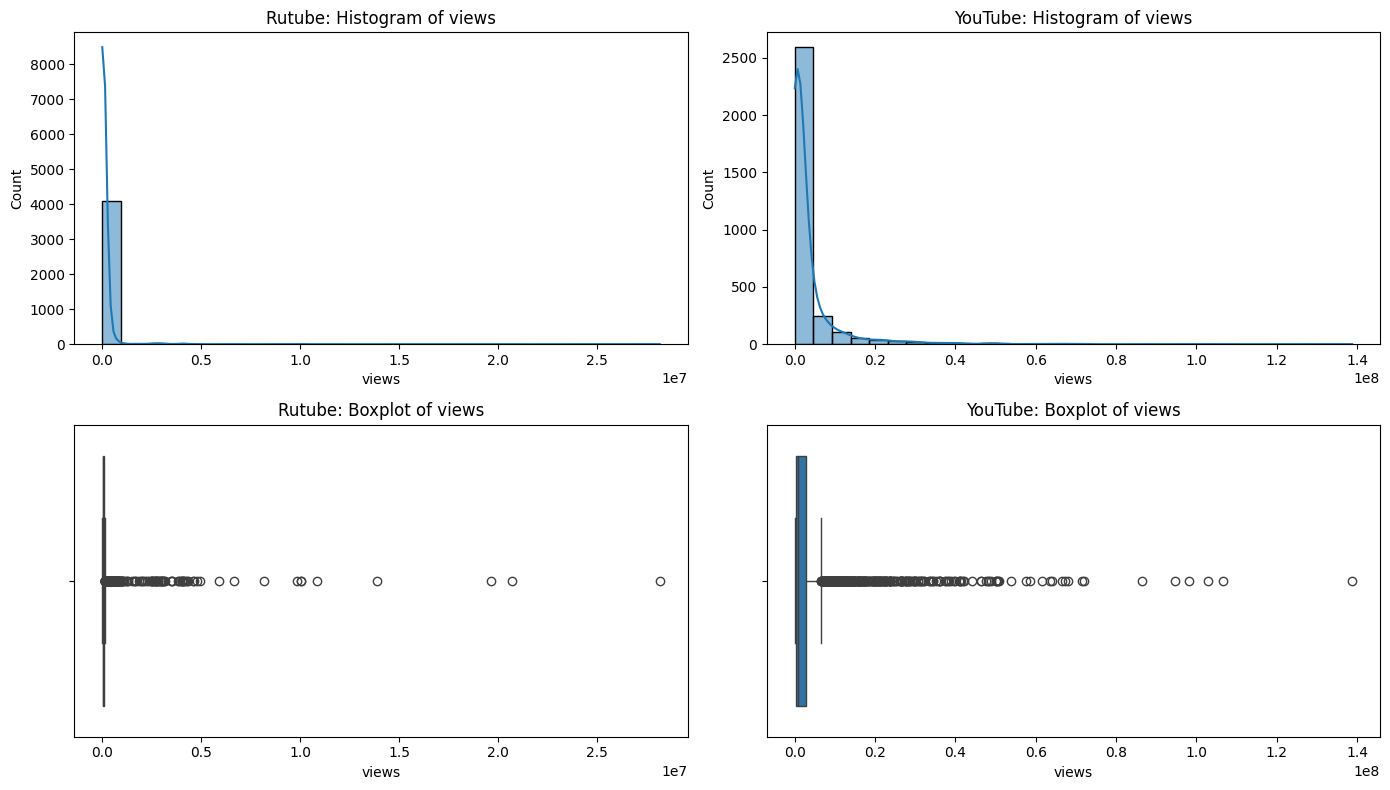

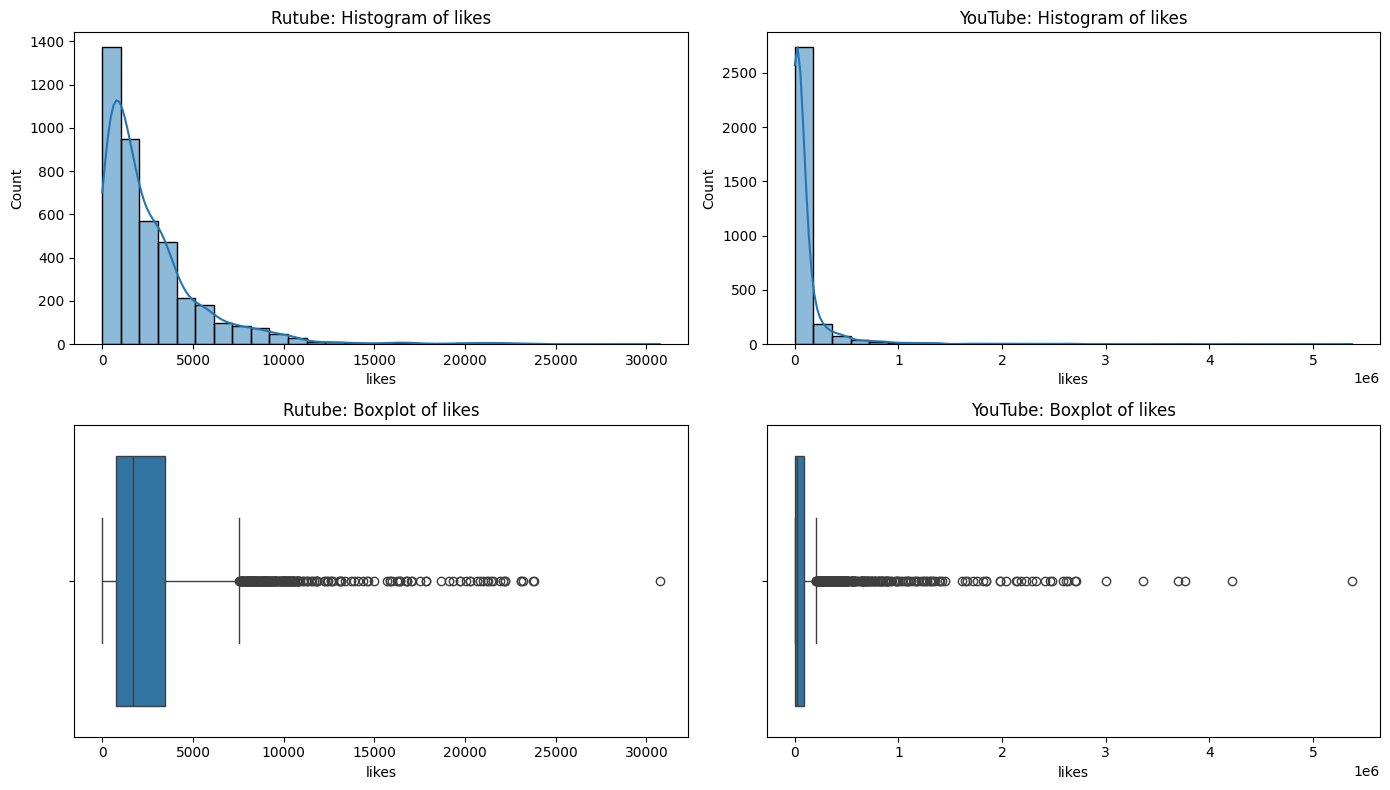

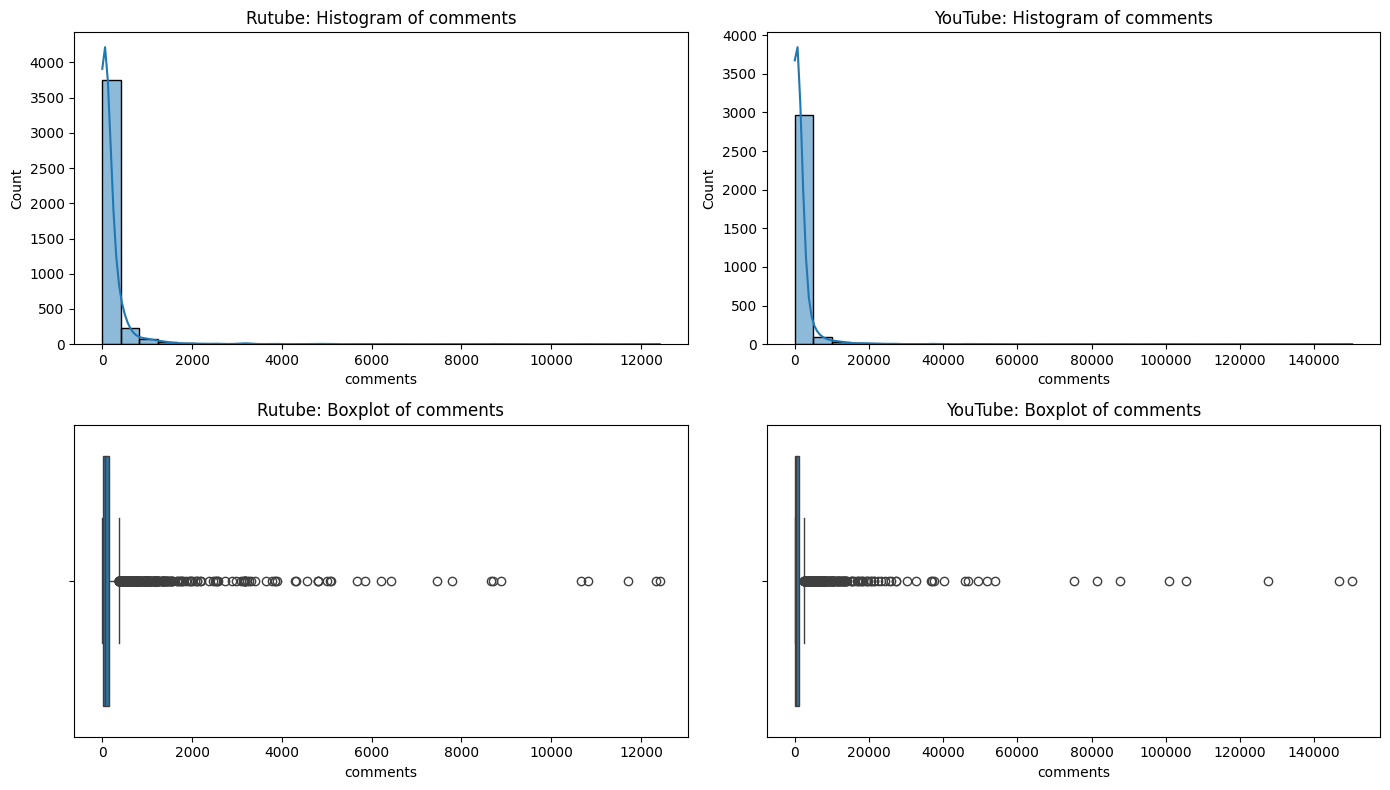

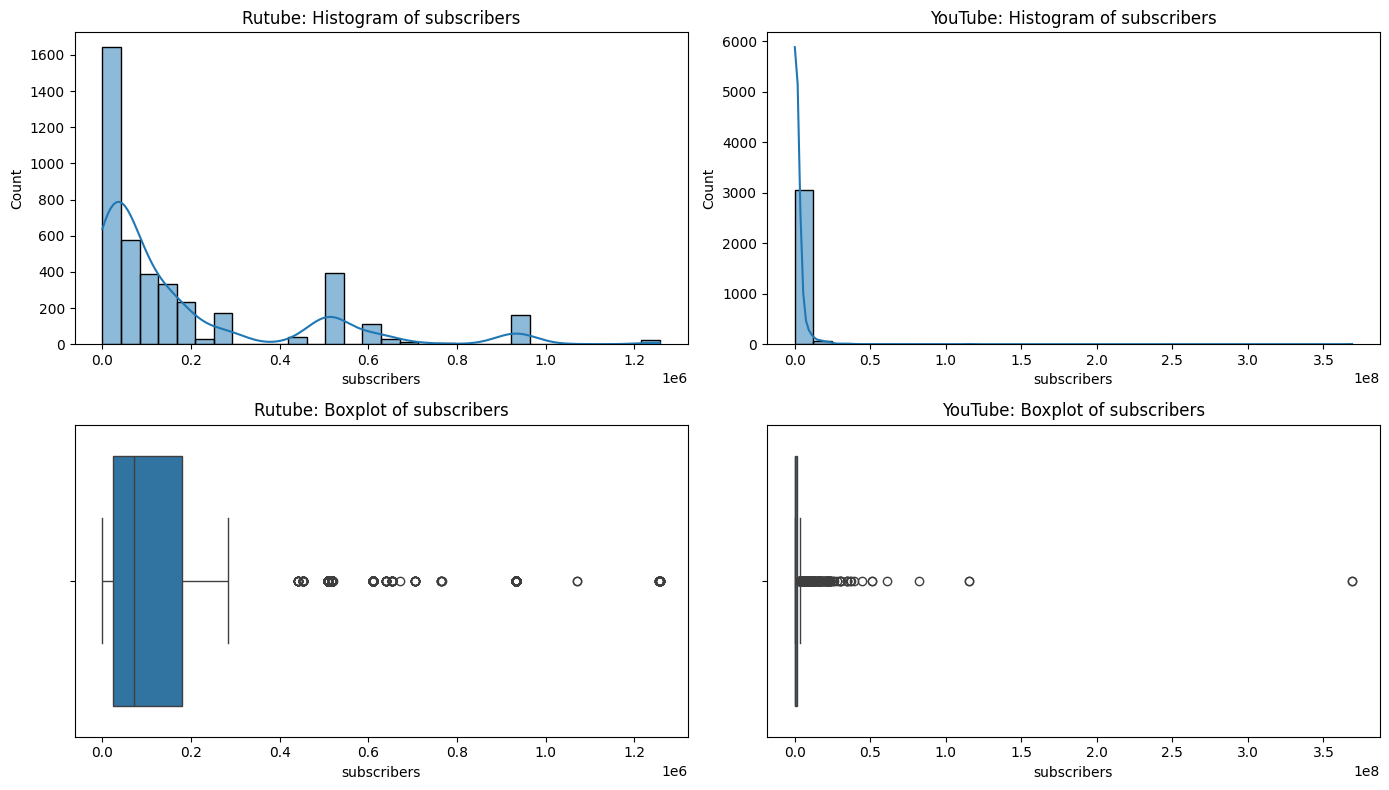

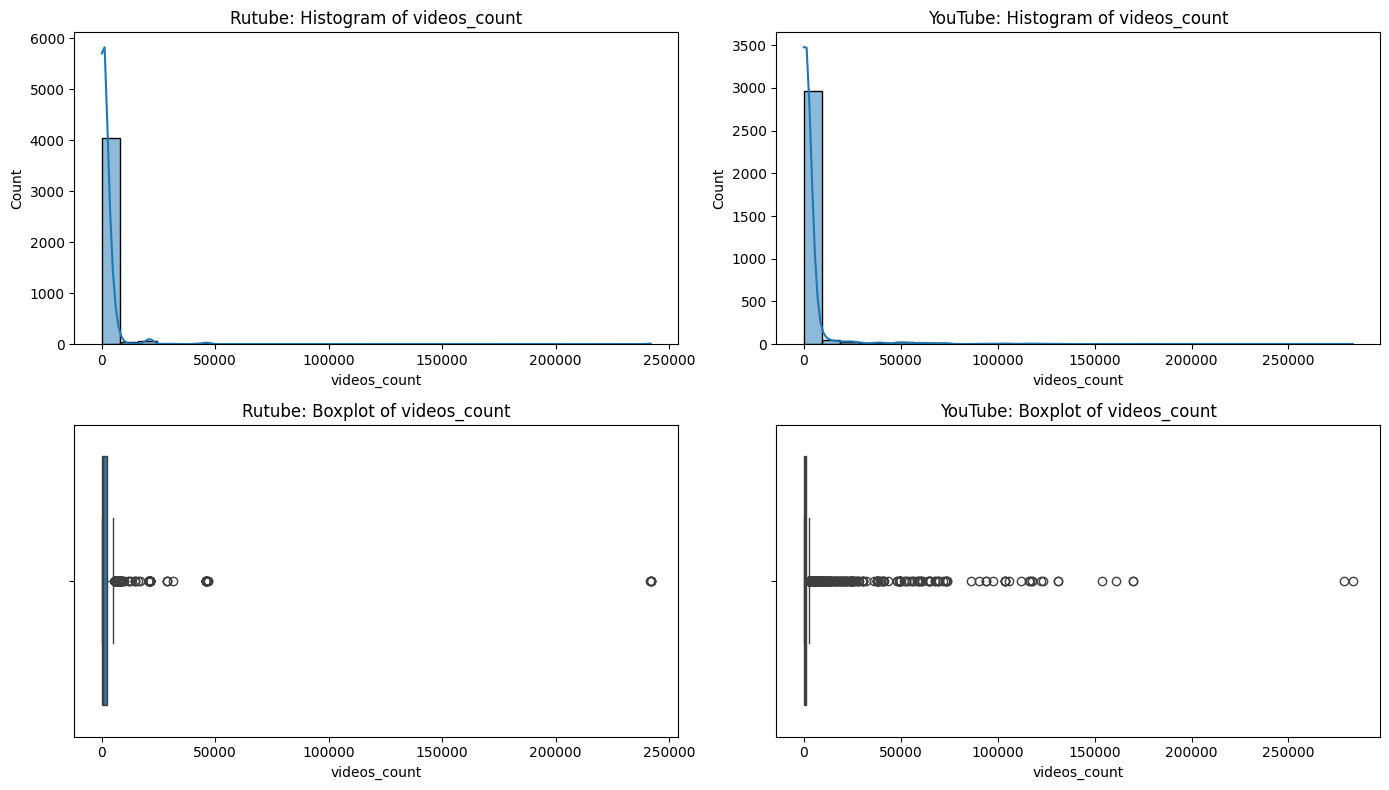

In [189]:
import seaborn as sns
import matplotlib.pyplot as plt

numeric_cols = ['views', 'likes', 'comments', 'subscribers', 'videos_count']

for col in numeric_cols:
    # Создаём отдельное окно с 4 подграфиками (2 строки, 2 столбца)
    fig, axes = plt.subplots(2, 2, figsize=(14, 8))

    # Данные для Rutube
    rutube_data = df_cleaned.loc[df_cleaned['source'] == 'Rutube', col].dropna()
    # Данные для YouTube
    youtube_data = df_cleaned.loc[df_cleaned['source'] == 'Youtube', col].dropna()

    # --- 1) Гистограмма Rutube ---
    sns.histplot(rutube_data, kde=True, bins=30, ax=axes[0, 0])
    axes[0, 0].set_title(f"Rutube: Histogram of {col}")

    # --- 2) Гистограмма YouTube ---
    sns.histplot(youtube_data, kde=True, bins=30, ax=axes[0, 1])
    axes[0, 1].set_title(f"YouTube: Histogram of {col}")

    # --- 3) Boxplot Rutube ---
    sns.boxplot(x=rutube_data, ax=axes[1, 0])
    axes[1, 0].set_title(f"Rutube: Boxplot of {col}")

    # --- 4) Boxplot YouTube ---
    sns.boxplot(x=youtube_data, ax=axes[1, 1])
    axes[1, 1].set_title(f"YouTube: Boxplot of {col}")

    plt.tight_layout()
    plt.show()

Без логарифмического преобразования не обойтись - при наличии очень больших значений (миллионы просмотров) и большого числа маленьких значений (несколько просмотров) логарифм «сжимает» масштаб и делает распределение более равномерным.

После логарифмического преобразования видно, что все метрики (просмотры, лайки, комментарии, подписчики и количество видео) имеют широкий диапазон значений, но становятся ближе к нормальному распределению. У большинства наблюдений показатели относительно невысокие (сконцентрированы ближе к нижней границе), а высокие значения встречаются реже и выступают как выбросы. Самое большое «растяжение» распределения наблюдается для просмотров и лайков, что подтверждает, что у небольшого числа видео показатели очень высокие. Количество видео на канале (videos_count) распределено более равномерно, но всё равно имеет заметное число каналов с относительно большим числом роликов. В целом данные демонстрируют сильную скошенность в исходном масштабе и лучше интерпретируются после логарифмической шкалы.

Избавимся от выбросов с помощью процентильного метода. Причем убирать будем перцентили по отдельности у rutube и youtube, т.к. размах данных сильно отличается у них, исходя из предыдущих графиков

In [202]:
def remove_outliers_percentile(df, columns, lower_percentile=1, upper_percentile=99):
    """
    Удаляет строки, где значения в указанных столбцах выходят
    за границы [lower_percentile; upper_percentile] процентилей.
    """
    df_clean = df.copy()
    df_clean_rutube = df_clean[df_clean['source'] == 'Rutube']
    df_clean_youtube = df_clean[df_clean['source'] == 'Youtube']
    
    for col in columns:
        low_val = df_clean_rutube[col].quantile(lower_percentile / 100.0)
        high_val = df_clean_rutube[col].quantile(upper_percentile / 100.0)
        df_clean_rutube = df_clean_rutube[(df_clean_rutube[col] >= low_val) & (df_clean_rutube[col] <= high_val)]
        
        low_val = df_clean_youtube[col].quantile(lower_percentile / 100.0)
        high_val = df_clean_youtube[col].quantile(upper_percentile / 100.0)
        df_clean_youtube = df_clean_youtube[(df_clean_youtube[col] >= low_val) & (df_clean_youtube[col] <= high_val)]
        
    df_clean = pd.concat([df_clean_rutube, df_clean_youtube], ignore_index=True)
    return df_clean

# Список числовых столбцов
numeric_cols = ['views', 'likes', 'comments', 'subscribers', 'videos_count']

# Считаем, сколько строк было до фильтрации
initial_count = df_cleaned.shape[0]

# Удаляем крайние 1% снизу и сверху по каждому числовому столбцу
df_cleaned_no_outliers = remove_outliers_percentile(
    df_cleaned, 
    columns=numeric_cols, 
    lower_percentile=1, 
    upper_percentile=93
)

# Считаем, сколько строк осталось
final_count = df_cleaned_no_outliers.shape[0]

print(f"До фильтрации: {initial_count} строк")
print(f"После фильтрации: {final_count} строк")
print(f"Удалено: {initial_count - final_count} строк")

До фильтрации: 7294 строк
После фильтрации: 4891 строк
Удалено: 2403 строк


Проверим распределения после фильтрации

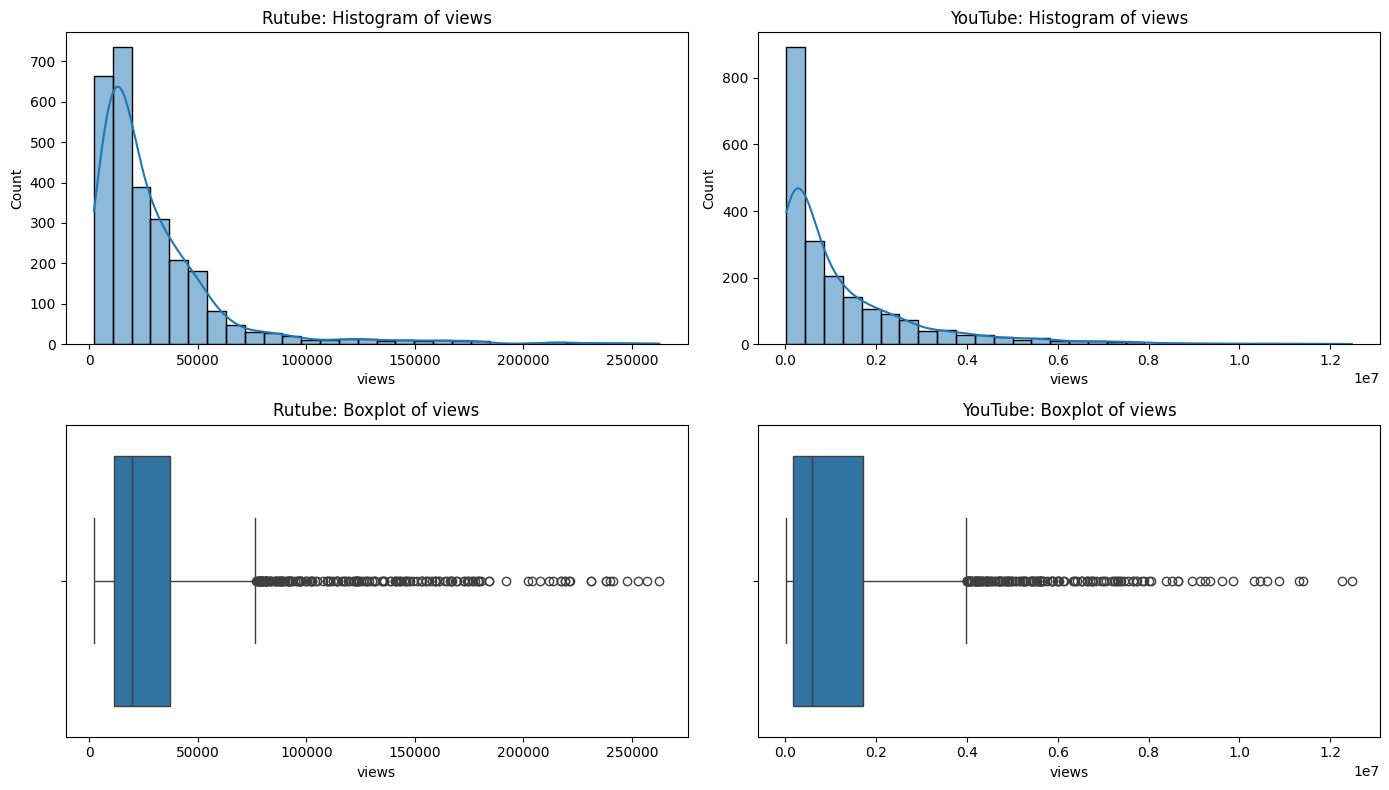

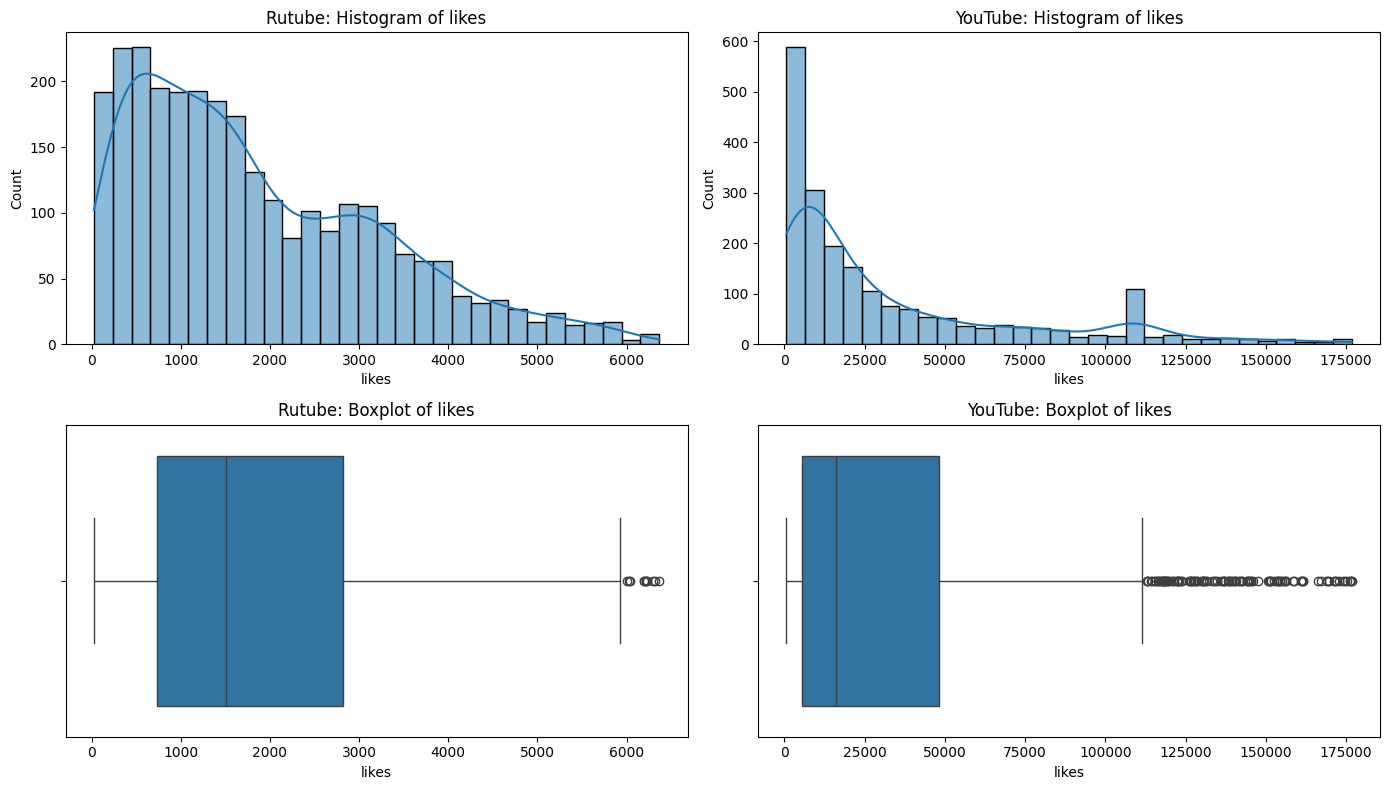

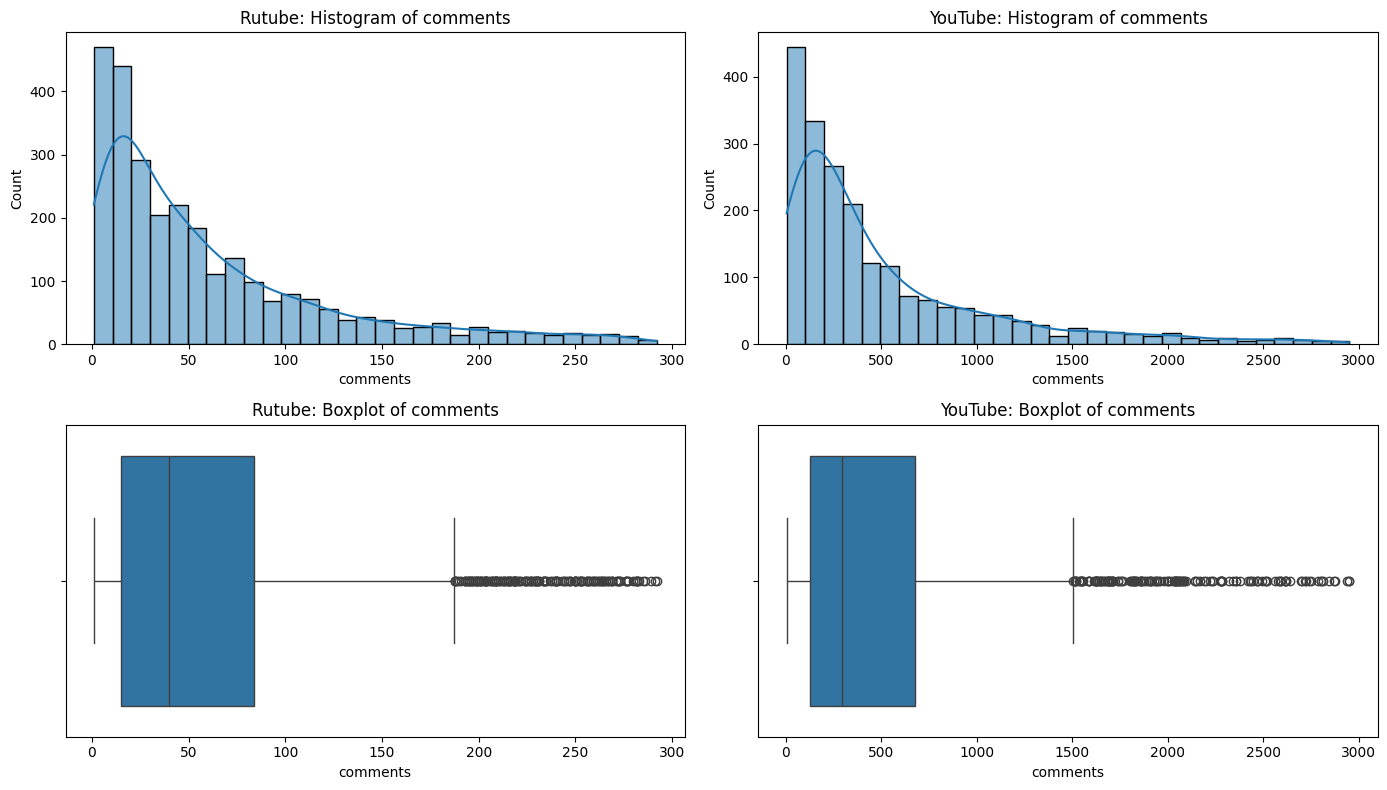

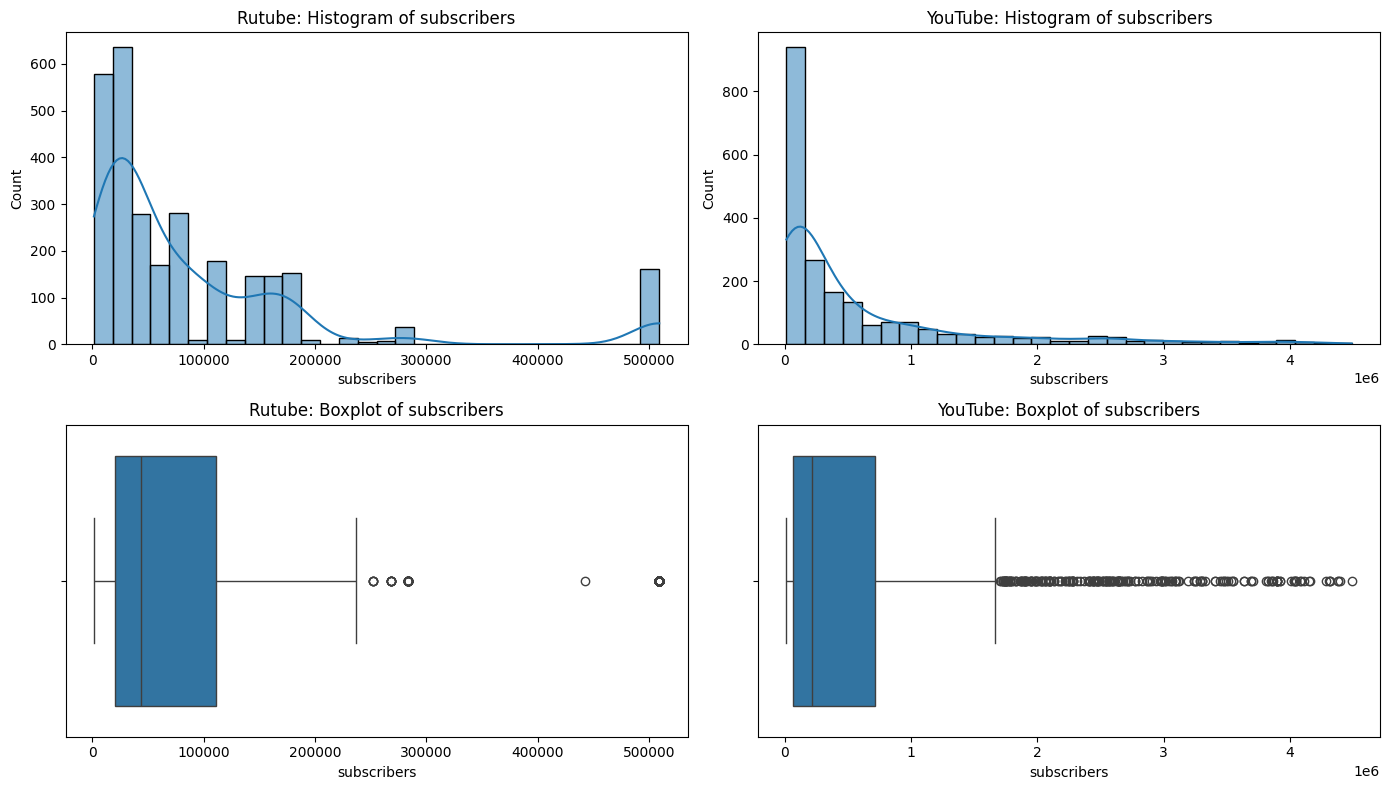

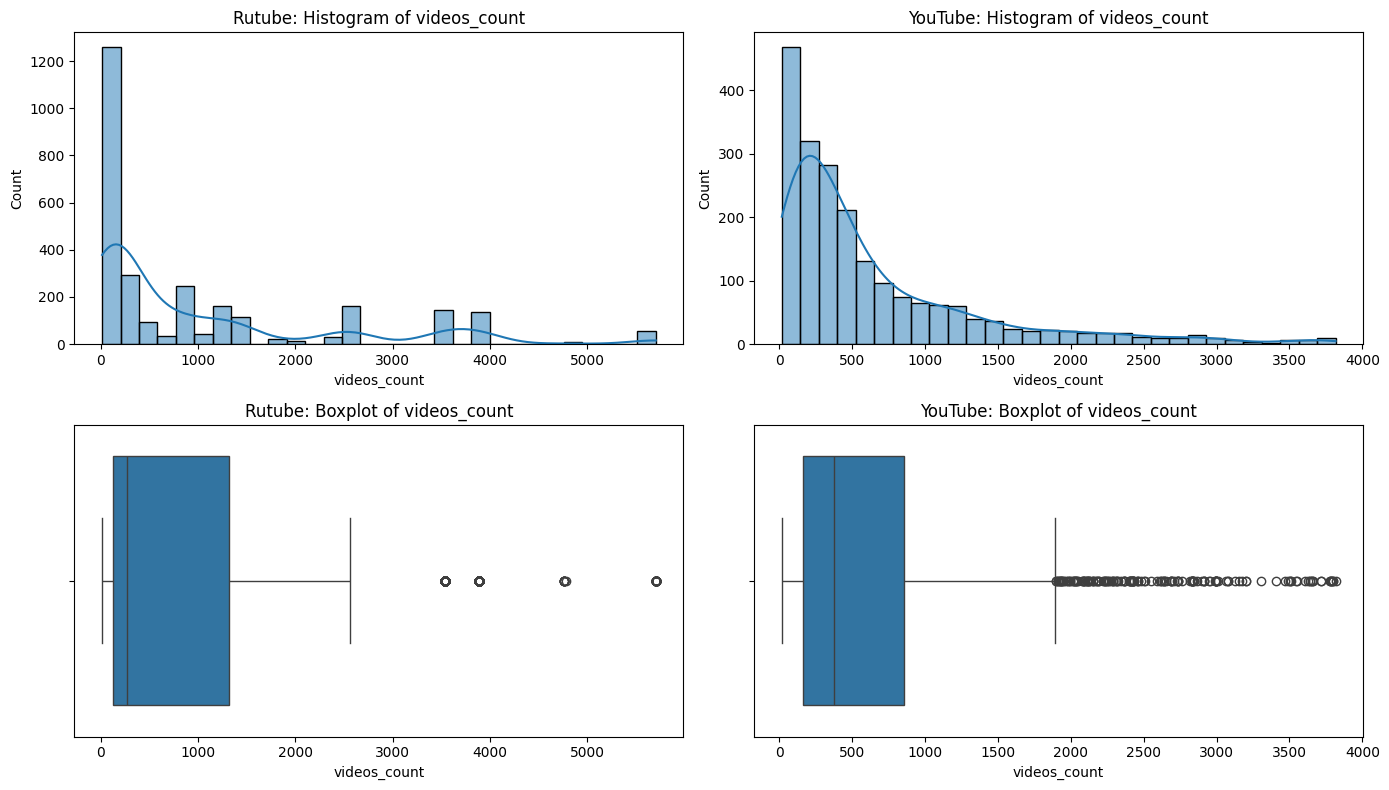

In [203]:
import seaborn as sns
import matplotlib.pyplot as plt

numeric_cols = ['views', 'likes', 'comments', 'subscribers', 'videos_count']

for col in numeric_cols:
    # Создаём отдельное окно с 4 подграфиками (2 строки, 2 столбца)
    fig, axes = plt.subplots(2, 2, figsize=(14, 8))

    # Данные для Rutube
    rutube_data = df_cleaned_no_outliers.loc[df_cleaned_no_outliers['source'] == 'Rutube', col].dropna()
    # Данные для YouTube
    youtube_data = df_cleaned_no_outliers.loc[df_cleaned_no_outliers['source'] == 'Youtube', col].dropna()

    # --- 1) Гистограмма Rutube ---
    sns.histplot(rutube_data, kde=True, bins=30, ax=axes[0, 0])
    axes[0, 0].set_title(f"Rutube: Histogram of {col}")

    # --- 2) Гистограмма YouTube ---
    sns.histplot(youtube_data, kde=True, bins=30, ax=axes[0, 1])
    axes[0, 1].set_title(f"YouTube: Histogram of {col}")

    # --- 3) Boxplot Rutube ---
    sns.boxplot(x=rutube_data, ax=axes[1, 0])
    axes[1, 0].set_title(f"Rutube: Boxplot of {col}")

    # --- 4) Boxplot YouTube ---
    sns.boxplot(x=youtube_data, ax=axes[1, 1])
    axes[1, 1].set_title(f"YouTube: Boxplot of {col}")

    plt.tight_layout()
    plt.show()

Subscribers и videos_count на rutube до сих пор содержат сильные выбросы, но остальные поля стали намного более сглаженными. Но по гистаграммам можно увидеть, что на rutube выброс подписчиков, где 500000 подписчиков, составляют немалую часть датасета.

Построим корреляционную матрицу **ЧЕРЕЗ ПЛОТЛИ!!** для числовых показателей (views, likes, comments, subscribers, videos_count), чтобы понять, какие метрики связаны между собой и какие могут быть полезны для построения моделей.

In [208]:
import plotly.express as px

numeric_cols = ['views', 'likes', 'comments', 'subscribers', 'videos_count']
corr_matrix = df_cleaned_no_outliers[numeric_cols].corr()

fig = px.imshow(
    corr_matrix,
    text_auto=True,
    color_continuous_scale='RdBu_r',
    title="Correlation Matrix for Numeric Metrics"
)
fig.show()

Теперь я бы сделал сентимент анализ комментариев

In [ ]:
!pip install textblob

In [210]:
from textblob import TextBlob

# Пример текста
text = "I love this product! It's amazing."

# Сентимент-анализ
blob = TextBlob(text)
sentiment = blob.sentiment

print(f"Polarity: {sentiment.polarity}")  # Полярность: от -1 (отрицательно) до 1 (положительно)

Polarity: Sentiment(polarity=0.6125, subjectivity=0.75)
Subjectivity: 0.75


In [212]:
df_cleaned_no_outliers[~df_cleaned_no_outliers['comments_likes'].isna()]

,published_at,views,likes,comments,category,subscribers,videos_count,source,comments_likes,tags
2819,2025-02-27T15:25:46Z,4930538,140508.000000,546.0,Comedy,139000.0,159.0,Youtube,"[('Фильм называется:Якутск,Сибирь', 0), ('Крич...",NaN
2820,2025-03-01T05:31:02Z,3554606,128546.000000,186.0,People & Blogs,4030000.0,1871.0,Youtube,"[('🎬 Сериал: «Менталист» 2008<br>📖 Сезон: 5, С...",NaN
2821,2025-02-28T10:45:03Z,3065431,108724.988146,1036.0,Film & Animation,1460000.0,1449.0,Youtube,"[('Мы так же ссоримся 😂😂😂😂😂😂😂😂😂😂😂😂😂', 0), ('Жн...",NaN
2822,2025-03-02T16:46:30Z,2062745,108724.988146,247.0,Film & Animation,84000.0,606.0,Youtube,[('никого не смутило то что оператор встал ког...,NaN
2823,2025-02-27T11:45:02Z,2920436,117359.000000,589.0,Film & Animation,2990000.0,1137.0,Youtube,[('Название: Следом за жизнью 🎥<br>Посмотреть ...,NaN
...,...,...,...,...,...,...,...,...,...,...
4886,2025-03-02T14:54:48Z,69279,4551.000000,312.0,News & Politics,95700.0,1063.0,Youtube,[('В Европе правят такие-же Зеленские что и в ...,"['новости и политика', 'узнай первым', 'Новост..."
4887,2025-03-01T06:19:52Z,363306,13219.000000,1436.0,People & Blogs,148000.0,41.0,Youtube,"[('Содержание:<br><a href=""https://www.youtube...","['ширяев и ширяев', 'ширяев военный эксперт', ..."
4888,2025-03-02T12:55:53Z,112368,2977.000000,446.0,News & Politics,31300.0,103.0,Youtube,"[('Народ вже давно списали, а він до цього час...","['росія україна', 'война в украине', 'европа',..."
4889,2025-02-26T08:03:52Z,217711,6022.000000,686.0,People & Blogs,76600.0,130.0,Youtube,[('2202 2080 8069 6496 (Сбер)- помощь нашим па...,NaN


In [220]:
dd = df_cleaned_no_outliers['comments_likes'].apply(lambda x: [(TextBlob(comment[0]).sentiment.polarity, comment[1]) for comment in eval(x)] if isinstance(x, str) else None)

0                                                    None
1                                                    None
2                                                    None
3                                                    None
4                                                    None
                              ...                        
4886    [(0.0, 0), (0.0, 0), (0.0, 1), (0.0, 2), (0.0,...
4887    [(0.0, 38), (0.0, 0), (0.0, 0), (0.0, 0), (0.0...
4888    [(0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0,...
4889    [(0.0, 35), (0.0, 0), (0.0, 0), (0.0, 0), (0.0...
4890    [(0.0, 98), (0.0, 0), (-0.5, 0), (0.0, 0), (0....
Name: comments_likes, Length: 4891, dtype: object

In [217]:
df_cleaned_no_outliers['comments_likes'].apply(lambda x: type(x))

0       <class 'float'>
1       <class 'float'>
2       <class 'float'>
3       <class 'float'>
4       <class 'float'>
             ...       
4886      <class 'str'>
4887      <class 'str'>
4888      <class 'str'>
4889      <class 'str'>
4890      <class 'str'>
Name: comments_likes, Length: 4891, dtype: object

In [218]:
df_cleaned_no_outliers['comments_likes']

0                                                     NaN
1                                                     NaN
2                                                     NaN
3                                                     NaN
4                                                     NaN
                              ...                        
4886    [('В Европе правят такие-же Зеленские что и в ...
4887    [('Содержание:<br><a href="https://www.youtube...
4888    [('Народ вже давно списали, а він до цього час...
4889    [('2202 2080 8069 6496 (Сбер)- помощь нашим па...
4890    [('🔴 URGENT SPRING SUPPORT SALE. 40% OFF Membe...
Name: comments_likes, Length: 4891, dtype: object